# Sciplex

In [1]:
import warnings
import os
import sys
import gc

In [2]:
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import tqdm
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
from tardis._utils.functions import label_transfer
from tardis._utils.warnings import suppress_stdout, ignore_predetermined_warnings
tardis.config = tardis.config_server
print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [4]:
num_ood = 1  # not functioning

In [5]:
def get_availables():
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.X = adata.layers["counts"].copy()
    del adata.layers
    adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
    d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
    adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
    df = adata.obs.groupby(["condition", "dose"]).size()
    df2 = adata.obs.groupby(["condition"]).size()
    availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
    return availables

In [6]:
def calculate_r2_raw(true_array, pred_array, batch_size):
    r2s = []
    start_ind = 0
    for end_ind in range(batch_size, len(true_array), batch_size):
        t = true_array[start_ind:end_ind]
        p = pred_array[start_ind:end_ind]
        r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
        r2s.append(r2)
        start_ind = end_ind
    return np.mean(r2s)

In [7]:
def shuffle_rows_with_rng(matrix, seed):
    shuffled_matrix = matrix.copy()    
    for i, row in enumerate(shuffled_matrix):
        rng = np.random.default_rng(i+seed)
        rng.shuffle(row)
    return shuffled_matrix

In [8]:
def get_r2_random(ood_seed, batch_size=32):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
        assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
        adata = ad.read_h5ad(adata_file_path)
        adata.X = adata.layers["counts"].copy()
        del adata.layers
        adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
        d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
        adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
        df = adata.obs.groupby(["condition", "dose"]).size()
        df2 = adata.obs.groupby(["condition"]).size()
        availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
        def adata_ood_creator(adata, seed, size):
            df = adata.obs.groupby(["condition", "dose"]).size()
            df2 = adata.obs.groupby(["condition"]).size()
            choices = [availables[ood_seed]]
            for choice in choices:
                print(choice)
            choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
            print(f"\nRemoved datapoint: {choices_bool.sum()}")
            return adata[~choices_bool, :].copy(), choices_bool
        adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

        model_name = f"sciplex_cat_ood-seed_expression-{ood_seed}_size-{num_ood}"
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.X = adata_main.layers["counts"].copy()
        del adata_main.layers
        adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
        d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
        adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()

        kk = ["condition", "dose"]
        ood_sample_specs = list(adata_ood.obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "baseline"})
        
        results.update({
            "train": calculate_r2_raw(adata.X.A[vae.train_indices], shuffle_rows_with_rng(adata.X.A[vae.train_indices], seed=ood_seed), batch_size=batch_size),
            "validation": calculate_r2_raw(adata.X.A[vae.validation_indices], shuffle_rows_with_rng(adata.X.A[vae.validation_indices], seed=ood_seed), batch_size=batch_size),
            "ood": calculate_r2_raw(adata_ood.X.A, shuffle_rows_with_rng(adata_ood.X.A, seed=ood_seed), batch_size=batch_size),
        })
        return results

In [9]:
def get_r2_cpa(ood_seed, batch_size=32):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")

        model_name = f"sciplex_cpa_ood-seed-{ood_seed}_size-{num_ood}"
        dir_path_latent = os.path.join(
            "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
            f"{model_name}.h5ad"
        )
        adata = ad.read_h5ad(dir_path_latent)

        adata_ood_obs = adata.obs[adata.obs.validation == "ood"]
        kk = ["condition", "dose"]
        ood_sample_specs = list(adata_ood_obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood_obs.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "cpa"})

        results.update({
            "train": calculate_r2_raw(adata.X.A[adata.obs.validation == "train"], adata.obsm["CPA_pred"][adata.obs.validation == "train"], batch_size=batch_size),
            "validation": calculate_r2_raw(adata.X.A[adata.obs.validation == "validation"], adata.obsm["CPA_pred"][adata.obs.validation == "validation"], batch_size=batch_size),
            "ood": calculate_r2_raw(adata.X.A[adata.obs.validation == "ood"], adata.obsm["CPA_pred"][adata.obs.validation == "ood"], batch_size=batch_size),
        })
        return results

In [10]:
def get_r2_tardis(ood_seed, batch_size=32):
    with warnings.catch_warnings(), suppress_stdout():
        warnings.simplefilter("ignore")
        adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_GSM_new.h5ad")
        assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
        adata = ad.read_h5ad(adata_file_path)
        adata.X = adata.layers["counts"].copy()
        del adata.layers
        adata.obs.loc[adata.obs["dose"] == "0.0", "dose_val"] = 0.0
        d = {i: ind for ind, i in enumerate(sorted(adata.obs["dose"].astype(float).unique()))}
        adata.obs["dose_training"] = [d[float(i)] for i in adata.obs["dose"]]
        df = adata.obs.groupby(["condition", "dose"]).size()
        df2 = adata.obs.groupby(["condition"]).size()
        availables = [(i, df[i]) for i in df.index if df[i] > 30 and df2[i[0]] > 200 and float(i[1])>4]
        def adata_ood_creator(adata, seed, size):
            df = adata.obs.groupby(["condition", "dose"]).size()
            df2 = adata.obs.groupby(["condition"]).size()
            choices = [availables[ood_seed]]
            for choice in choices:
                print(choice)
            choices_bool = np.vstack([(adata.obs["condition"] == choice[0][0]) & (adata.obs["dose"] == choice[0][1]) for choice in choices]).any(axis=0)
            print(f"\nRemoved datapoint: {choices_bool.sum()}")
            return adata[~choices_bool, :].copy(), choices_bool
        adata, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)

        model_name = f"sciplex_cat_ood-seed_expression-{ood_seed}_size-{num_ood}"
        dir_path = os.path.join(
            tardis.config.io_directories["models"],
            model_name
        )
        vae = tardis.MyModel.load(dir_path, adata=adata)
        from tardis._disentanglementmanager import DisentanglementManager as DM
    
        adata_main = ad.read_h5ad(adata_file_path)
        adata_main.X = adata_main.layers["counts"].copy()
        del adata_main.layers
        adata_main.obs.loc[adata_main.obs["dose"] == "0.0", "dose_val"] = 0.0
        d = {i: ind for ind, i in enumerate(sorted(adata_main.obs["dose"].astype(float).unique()))}
        adata_main.obs["dose_training"] = [d[float(i)] for i in adata_main.obs["dose"]]
        adata_main.obs["ood"] = choices_bool.astype(int).astype(str)
        adata_main.obs["ood"] = adata_main.obs["ood"].astype("category")
        adata_ood = adata_main[adata_main.obs["ood"] == "1"].copy()
        
        kk = ["condition", "dose"]
        ood_sample_specs = list(adata_ood.obs[kk].drop_duplicates().to_numpy()[0])
        results = {j: ood_sample_specs[i] for i, j in enumerate(kk)}
        results.update({"ood_seed": ood_seed, "model_name": model_name})
        results.update({"ood_size": adata_ood.shape[0], "reference_size": adata.shape[0]})
        results.update({"model": "tardis"})
        
        results.update({
            "train": vae.get_reconstruction_r2(adata, indices=vae.train_indices, batch_size=batch_size, drop_last = True),
            "validation": vae.get_reconstruction_r2(adata, indices=vae.validation_indices, batch_size=batch_size, drop_last = True),
            "ood": vae.get_reconstruction_r2(adata_ood, batch_size=batch_size)
        })
        return results

In [11]:
availables = get_availables()
result_list = []

In [12]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    result_list.append(get_r2_random(ood_seed))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:40<00:00,  2.86s/it]


In [13]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    result_list.append(get_r2_tardis(ood_seed))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:29<00:00,  2.14s/it]


In [20]:
for ood_seed in tqdm.tqdm(range(len(availables))):
    try:
        result_list.append(get_r2_cpa(ood_seed))
    except FileNotFoundError:
        print(ood_seed)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:18<00:00,  1.33s/it]


In [21]:
df = pd.DataFrame(result_list)
df

,condition,dose,ood_seed,model_name,ood_size,reference_size,model,train,validation,ood
0,BMS,5.0,0,sciplex_cat_ood-seed_expression-0_size-1,193,14618,baseline,-0.055900,-0.056641,-0.068714
1,BMS,10.0,1,sciplex_cat_ood-seed_expression-1_size-1,153,14658,baseline,-0.055390,-0.057175,-0.078280
2,BMS,50.0,2,sciplex_cat_ood-seed_expression-2_size-1,34,14777,baseline,-0.056022,-0.057864,-0.054405
3,Dex,5.0,3,sciplex_cat_ood-seed_expression-3_size-1,694,14117,baseline,-0.056288,-0.055960,-0.049499
4,Dex,10.0,4,sciplex_cat_ood-seed_expression-4_size-1,704,14107,baseline,-0.055960,-0.057262,-0.052254
5,Dex,50.0,5,sciplex_cat_ood-seed_expression-5_size-1,864,13947,baseline,-0.056048,-0.055870,-0.051578
6,Dex,100.0,6,sciplex_cat_ood-seed_expression-6_size-1,790,14021,baseline,-0.056548,-0.057945,-0.050709
7,Nutlin,5.0,7,sciplex_cat_ood-seed_expression-7_size-1,486,14325,baseline,-0.056087,-0.058759,-0.042145
8,Nutlin,10.0,8,sciplex_cat_ood-seed_expression-8_size-1,657,14154,baseline,-0.056421,-0.056980,-0.050841
9,Nutlin,50.0,9,sciplex_cat_ood-seed_expression-9_size-1,265,14546,baseline,-0.056118,-0.056816,-0.058024


In [22]:
value_vars = ['train', 'validation', 'ood']
id_vars = [i for i in df.columns if i not in value_vars]
df_melted = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='split', value_name='r2')

# Plots

(0.5, 1.0)

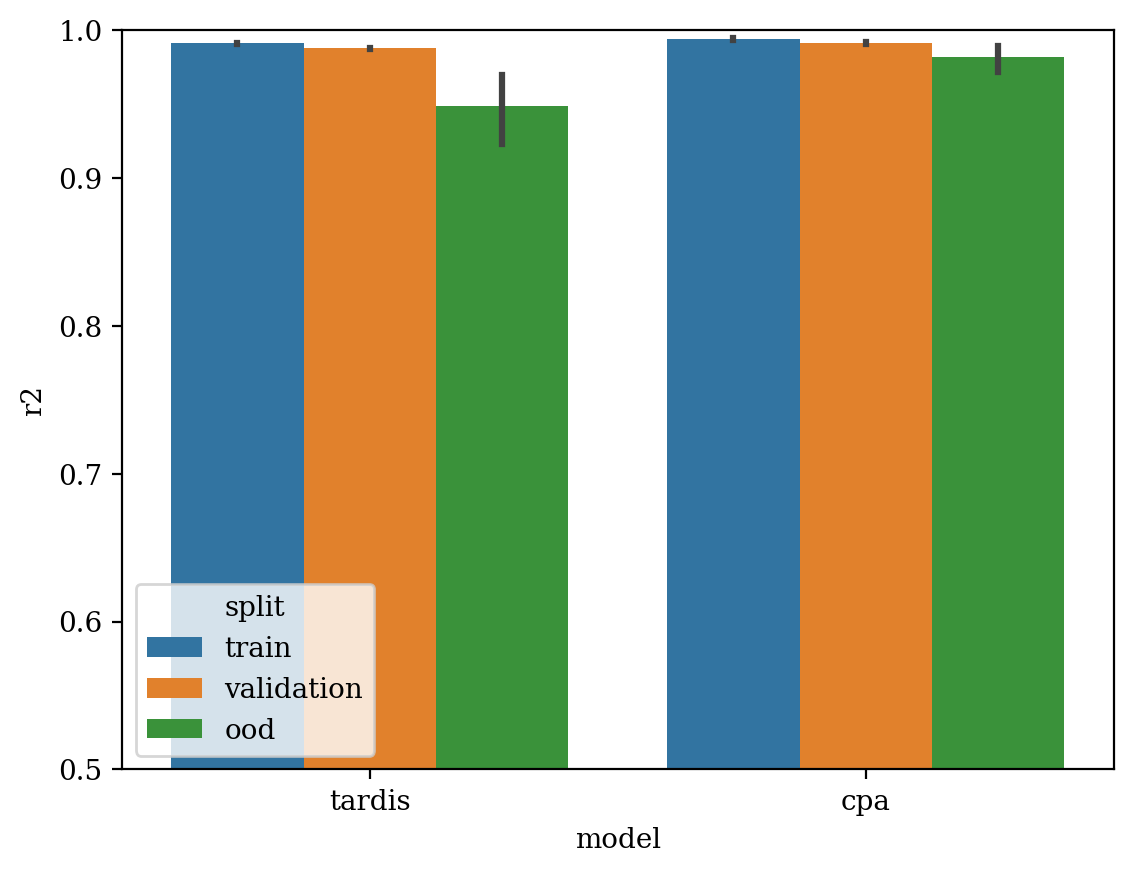

In [37]:
df_melted_ = df_melted[df_melted["model"] != "baseline"]
sns.barplot(data=df_melted_, x="model", y='r2', hue="split")
plt.ylim(0.5, 1)

<Axes: xlabel='split', ylabel='r2'>

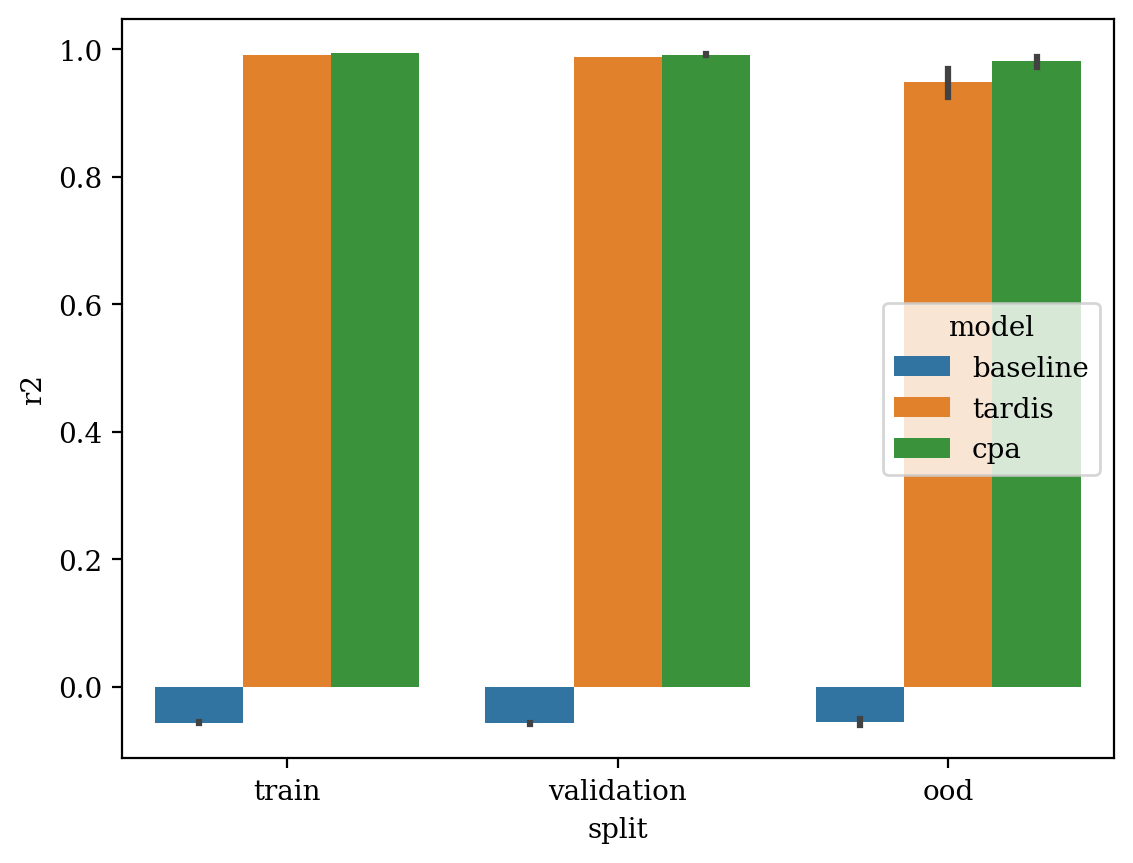

In [38]:
sns.barplot(data=df_melted, x="split", y='r2', hue="model")

In [36]:
df_melted.to_pickle(
    os.path.join(tardis.config.io_directories["processed"], "figures", "figure7_sciplex.pickle")
)